In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.optim import lr_scheduler
from d2l import torch as d2l

In [2]:
def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84),  nn.ReLU(),
        nn.Linear(84, 10)
    )
    return model
loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

In [3]:
def train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # store train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()  # 进入训练模式
            trainer.zero_grad()  # 梯度清零
            X, y = X.to(device), y.to(device)
            y_hat = net(X)  # 计算预测值
            l = loss(y_hat, y)  # 计算损失
            l.backward()  # 反向传播
            trainer.step()  # 参数更新
            with torch.no_grad():
                metric.add(l*X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]  # 计算训练损失
            train_acc = metric[1] / metric[2]   # 计算测试损失
            if (i+1) % 50 == 0:
                animator.add(epoch + i / len(train_iter), (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # UsingPyTorchIn-Builtscheduler
                scheduler.step()
            else:
                # Usingcustomdefinedscheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f},'
          f'test acc {test_acc:.3f}')

KeyboardInterrupt: 

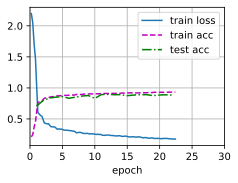

In [12]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

In [11]:
# 学习率调度器，我们可以在每个迭代数（甚至在每个小批量）之后向下调整学习率。例如，以动态的方式来响应优化的进展情况。
lr = 0.1
trainer.param_groups[0]['lr'] = lr
print(f"learning rate is now {trainer.param_groups[0]['lr']}")

learning rate is now 0.1


In [13]:
# 更通常而言，我们应该定义一个调度器，当调用更新次数时，它将返回学习率的适当值
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

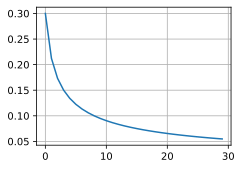

In [14]:
# 绘制lr变化图
scheduler = SquareRootScheduler(lr=0.3)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

KeyboardInterrupt: 

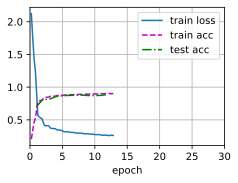

In [15]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

In [17]:
# 比以前好一些：曲线比以前更平滑，并且过拟合更小了。遗憾的是，关于为什么在理论上某些策略会导致较轻的过拟合，有一些观点认为，
# 较小的步长将导致参数更新更接近零，因此更简单。但是，这并不能完全解释这种现象，因为我们并没有真正地提前停止，而只是降低了学习率。

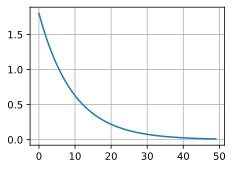

In [16]:
# 单因子调度器
# 多项式衰减的一种替代方案是乘法衰减，为了防止学习率衰减到一个合理的下界之下，更新方程经常提供一个最小值
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.3):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr = 2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

In [17]:
# 接下来，我们将使用内置的调度器，但在这里仅解释它们的功能
# 多因子调度器
# 训练神经网络的常见策略之一是保持学习率为一组分段的常量，并且不时地按给定的参数对学习率做乘法衰减。具体地说，给定一组降低学习率的时间点，例如 s={5, 10, 20} 当t属于s时，降低学习率，假设每步中的值减半

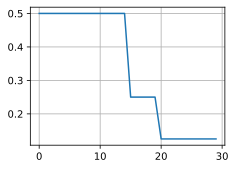

In [18]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 20], gamma=0.5)

def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr
d2l.plot(torch.arange(num_epochs), [get_lr(trainer, scheduler) for t in range(num_epochs)])

In [19]:
# 余弦调度器
# 余弦调度器时一种启发式算法。它所依据的观点是：我们可能不想在一开始就太大地降低学习率，而且可能希望最终能用非常小
# 的学习率来改进解决方案。这产生了一个类似于余弦的调度

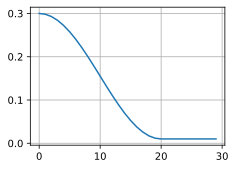

In [5]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0, warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orgin = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):
        increase = (self.base_lr_orgin - self.warmup_begin_lr) * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (self.base_lr_orgin - self.final_lr) * (1+math.cos(math.pi * (epoch - self.warmup_steps)/self.max_steps)) / 2
        return self.base_lr

num_epochs = 30
scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

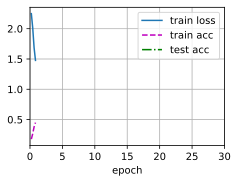

In [24]:
# 在cv的背景下，这个调度方式可能产生改进的结果。但这种改进并不一定成立
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

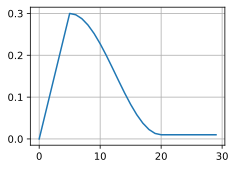

In [22]:
# 预热
# 在某些情况下，初始化参数不足以得到良好的解。这对某些高级网络设计来说尤其棘手，可能导致不稳定的优化结果。对此，
# 一方面，我们可以选择一个足够小的学习率，从而防止一开始发散，然而这样进展太缓慢。另一方面，较高的学习率最初就会导致发散。
# 解决这种困境的一个相当简单的解决方法是使用预测期，在此期间学习率将增加至初始最大值，然后冷却直到优化过程结束。为了
# 简单起见，通常使用线性递增。这引出了如下表所示的时间表
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.169, train acc 0.938,test acc 0.905


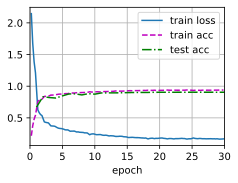

In [6]:
# 注意，观察前5个迭代轮数的性能，网络最初收敛得很好
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
num_epochs = 30
train(net, train_iter, test_iter, num_epochs, loss, trainer, device, scheduler)

In [7]:
scheduler.__module__

'__main__'

In [8]:
lr_scheduler.__name__

'torch.optim.lr_scheduler'